In [1]:
 %run /Desktop/Share/CUDA_DEVICE_setup.py -n 1

using GPU ID:0,



In [2]:
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [3]:
#%config Completer.use_jedi = False

import sys
sys.path.append('..')


from pprint import pprint    
import tensorflow as tf    
from collections import defaultdict
from sklearn.metrics import r2_score
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime

from tndm.data import DataManager
from tndm import LFADS
from tndm.runtime import Runtime
from typing import Dict, Any
from sklearn.linear_model import Ridge

from plotting import *

In [4]:
# read the data/disk/scratch/cole/Chewie_CO_FF_2016-10-07_pos_M1_spikes/test_data/
spike_data_dir = "Chewie_CO_FF_2016-10-07_pos_M1_spikes/"

data_dir = os.path.join( spike_data_dir )

dataset, settings = DataManager.load_dataset(
    directory=data_dir,
    filename='dataset.h5')

#train
neural_data = dataset['train_data'].astype('float')
behavioural_data = dataset['train_behaviours'].astype('float')

# valid
valid_neural_data = dataset['valid_data'].astype('float')
valid_behavioural_data = dataset['valid_behaviours'].astype('float')

# test
test_neural_data = dataset['test_data'].astype('float')
test_behavioural_data = dataset['test_behaviours'].astype('float')

# get dataset, to train by myself
# with_behaviour = False for lfads
# target = input for reconstruction

In [5]:
(x_train, y_train), (x_val, y_val) = Runtime.clean_datasets(
            train_dataset=(neural_data, behavioural_data), 
            val_dataset=(valid_neural_data, valid_behavioural_data), 
            with_behaviour=False
            )

In [6]:
x_test = test_neural_data
y_test = test_behavioural_data

In [7]:
def print_data_shape(data):
    if data is not None:
        print(data.shape)
    else:
        print("None")

In [8]:
print_data_shape(x_train)
print_data_shape(y_train)
print_data_shape(x_val)
print_data_shape(y_val)
print_data_shape(x_test)
print_data_shape(y_test)

(136, 73, 70)
None
(17, 73, 70)
None
(17, 73, 70)
(17, 73, 2)


# Quantize data first
## the input and last layer will remain ap<16,6> precision

In [12]:
AP_BITS = 16
AP_INTS = 6

In [13]:
# ususal quantize
from qkeras import QActivation
ACTIVATION_BITS = "quantized_bits({}, {}, alpha=1)".format(AP_BITS, AP_INTS-1)

# model parameters

In [14]:
# model parameters

# l2 regulariser for the recurrent decoder weights
l2_reg = .1
initial_neural_weight = 1.0 # weight of neural nll
initial_behaviour_weight = .2 # weight of behaviour loss
lambda_q = 100.0
update_rate = .0005
dropout = .15
#seed = 0
#GRU_pre_activation = False
#var_min = 0.0001
#prior_variance = 1
threshold_poisson_log_firing_rate = 100.


layers_settings=defaultdict(lambda: dict(
    kernel_initializer=tf.keras.initializers.VarianceScaling(
        scale=1.0, mode='fan_in', distribution='normal'),
    kernel_regularizer=tf.keras.regularizers.l2(l=0.0)
))

layers_settings['decoder'].update(dict(kernel_regularizer=tf.keras.regularizers.l2(l=0),
                                      recurrent_regularizer=tf.keras.regularizers.l2(l=l2_reg),
                                      original_cell=False))    

In [15]:
pprint(layers_settings)

defaultdict(<function <lambda> at 0x7f29d3f2b9d0>,
            {'decoder': {'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling object at 0x7f29d3f3f730>,
                         'kernel_regularizer': <keras.regularizers.L2 object at 0x7f29d3f3f8b0>,
                         'original_cell': False,
                         'recurrent_regularizer': <keras.regularizers.L2 object at 0x7f29d3f3f910>}})


In [16]:
layers_settings['encoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f29d3f28dc0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f29d3f28910>}

In [17]:
layers_settings['decoder']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f29d3f3f730>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f29d3f3f8b0>,
 'recurrent_regularizer': <keras.regularizers.L2 at 0x7f29d3f3f910>,
 'original_cell': False}

In [18]:
layers_settings['dense_mean']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f2928fcb9a0>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f29d3f28fd0>}

In [19]:
layers_settings['dense_logvar']

{'kernel_initializer': <keras.initializers.initializers_v2.VarianceScaling at 0x7f29d3f28e20>,
 'kernel_regularizer': <keras.regularizers.L2 at 0x7f29d3f287f0>}

## function to build the model

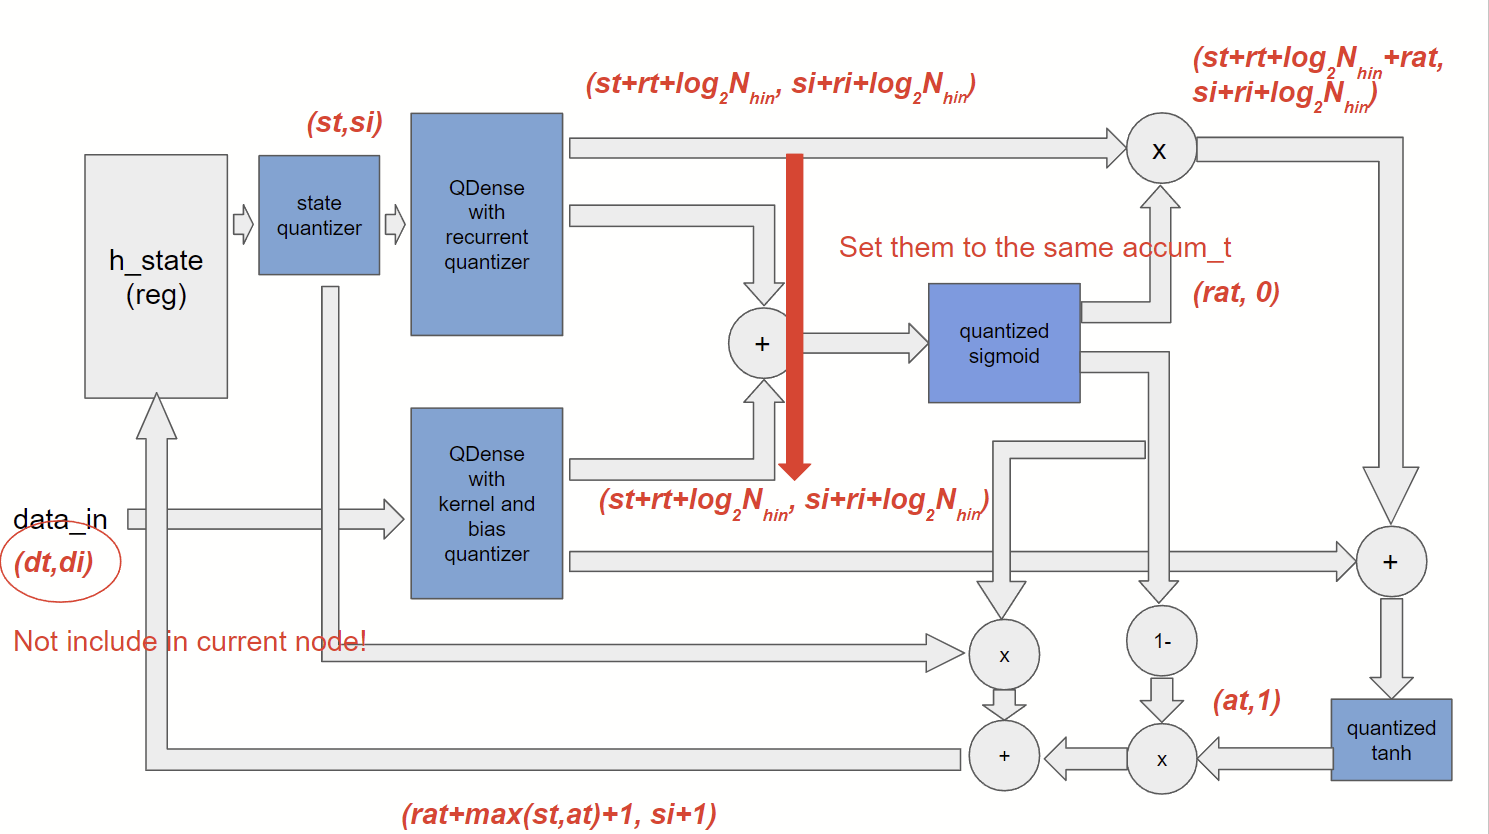

## the ACCUM bits in QGRU is based on the state quantizer, so the previous act_quan precision should be less than it
## here set the state quantizer same as the act_quan

# input for decoder GRU
# Assuming inputs are zero and everything comes from the GRU

In [20]:
decoder_dim = 64

In [21]:
def get_decoder_input(decoder_dim=64):
    inputs2decoder_train = tf.stack([tf.zeros_like(x_train)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_val = tf.stack([tf.zeros_like(x_val)[:, :, -1]
                for i in range(decoder_dim)], axis=-1)
    inputs2decoder_train = np.array(inputs2decoder_train)
    inputs2decoder_val = np.array(inputs2decoder_val)
    print("inputs2decoder_train shape: ", inputs2decoder_train.shape)
    print("inputs2decoder_val shape: ", inputs2decoder_val.shape)
    return inputs2decoder_train, inputs2decoder_val

# Build models

In [22]:
inputs2decoder_train, inputs2decoder_val = get_decoder_input(decoder_dim=decoder_dim)

inputs2decoder_train shape:  (136, 73, 64)
inputs2decoder_val shape:  (17, 73, 64)


In [23]:
#pred_val_z, pred_val_logf = fmodel.predict([x_val, inputs2decoder_val])

In [24]:
def evaluate_NPLL(targets, pred_logrates):
    targets = tf.cast(targets, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(0.01) + pred_logrates, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(targets=targets,log_input=logrates, compute_full_loss=True)
    results = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    results = tf.reduce_mean(results) # batch mean

    print(results) # negative possion loglikelihood

In [25]:
#evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

In [26]:
#del fmodel

# loss: poisson_loglike_loss

In [27]:
from tensorflow.keras import backend as K

In [28]:
BATCH_SIZE=16

In [29]:
timestep = 0.01

def poisson_loglike_loss(y_true, y_pred):    
    # POISSON LOG-LIKELIHOOD
    # clip the y_pred first
    y_pred = tf.clip_by_value(y_pred, 
                                     clip_value_min=-threshold_poisson_log_firing_rate,
                                     clip_value_max=threshold_poisson_log_firing_rate
                             )
    targets = tf.cast(y_true, dtype=tf.float32)
    logrates = tf.cast(tf.math.log(timestep) + y_pred, tf.float32)  # Timestep
    npll = tf.nn.log_poisson_loss(
        targets=targets,
        log_input=logrates, compute_full_loss=True
    )
    #print(npll.shape)
    loss = tf.reduce_sum(npll, axis=[1, 2]) # sum up each batch seperately
    loss = tf.reduce_mean(loss) # batch mean
    #loss = tf.reduce_sum()
    return loss

## Build a fp model and train

In [30]:
import tensorflow.keras.layers as tfl
from tensorflow.keras import Model
import tensorflow as tf
from tensorflow import keras

In [31]:
class ExponentLogvar(tfl.Layer):
    def __init__(self):
        super().__init__()
        
    def call(self, inputs):
        return tf.exp(0.5 * inputs) 

In [32]:
class StandardRandomNormal(tfl.Layer):
    def __init__(self, seed=42, n_samples=4):
        super().__init__()
        self.seed = seed
        self.n_samples = n_samples

    def call(self, inputs):
        return K.random_normal(shape=tf.shape(inputs), mean=0.0, stddev=1.0, seed=self.seed)
    
    def get_config(self):
        config = super().get_config()
        config.update(
            {
            "seed": self.seed,
            "n_samples":  self.n_samples
            })
        return config                

## Build the encoder

In [33]:
def create_fpencoder(input_shape = (73,70),
                    encoder_dim=64,  
                   drop=dropout
                  ):
    
    # input layer
    inputLayer =  tfl.Input(shape=input_shape, name = 'encoder_input')        
    x = tfl.Dropout(drop, name = 'initial_dropout')(inputLayer)
    
    # encoder
    forward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUForward",
            return_state=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
            )
    
    backward_layer = tfl.GRU(
            encoder_dim, 
            time_major=False,
            name="EncoderGRUBackward",
            return_state=True, 
            go_backwards=True,
            kernel_regularizer=layers_settings['encoder']['kernel_regularizer'],
            kernel_initializer=layers_settings['encoder']['kernel_initializer'],
             )
                
    x = tfl.Bidirectional(
        forward_layer, 
        backward_layer=backward_layer,
        merge_mode='concat', 
        name = 'Encoder_BidirectionalGRU'
        )(x)[0]  
    
    x = tfl.Dropout(drop, name = 'postencoder_dropout')(x)

    # latent space    
    z_mean = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_mean']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_mean']['kernel_initializer'],
               name='dense_mean'
              )(x)
    z_log_var = tfl.Dense(decoder_dim, 
               kernel_regularizer=layers_settings['dense_logvar']['kernel_regularizer'],
               kernel_initializer=layers_settings['dense_logvar']['kernel_initializer'],
               name='dense_logvar'
              )(x)
    
    # sample 
    # z_mean + tf.exp(0.5 * z_log_var) * epsilon
    epsilon = StandardRandomNormal()(z_mean)
    z_var = ExponentLogvar()(z_log_var)
    z_var = tfl.Multiply()([z_var, epsilon])
    
    z = tfl.Add()([z_mean, z_var])
    
    encoder = Model(inputs = inputLayer, outputs = [z_mean, z_log_var, z], name="encoder")
    
    return encoder
    

In [34]:
encoder = create_fpencoder()

In [35]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 73, 70)]     0           []                               
                                                                                                  
 initial_dropout (Dropout)      (None, 73, 70)       0           ['encoder_input[0][0]']          
                                                                                                  
 Encoder_BidirectionalGRU (Bidi  [(None, 128),       52224       ['initial_dropout[0][0]']        
 rectional)                      (None, 64),                                                      
                                 (None, 64)]                                                      
                                                                                            

In [36]:
from tensorflow.keras.utils import plot_model


In [41]:
plot_model(encoder)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# Build the decoder

## since the latent vector will become the initial state of the decoder GRU, 
## decoder_dim = latent dimension

In [42]:
def create_fpdecoder(input_shape = (73,70),
                     decoder_dim=decoder_dim,  
                     factors = 4,
                     drop=dropout
                     ):
    
    # decoder
    input_decoder_shape = (input_shape[0], decoder_dim) #( 73 timesteps, 64 decoder_dim)
    input_decoder = tfl.Input(shape=input_decoder_shape, name = 'decoder_input')
    
    # sampled latent 
    latent_inputs = tfl.Input(shape=(decoder_dim,), name = 'latent_input')
        
    x = tfl.GRU(
                decoder_dim,                
                return_sequences=True,
                time_major=False,
                name='DecoderGRU'
                )(input_decoder, initial_state = latent_inputs)
    x = tfl.Dropout(drop, name = 'postdecoder_dropout')(x)
    
    # DIMENSIONALITY REDUCTION
    z = tfl.Dense(
            factors, 
            use_bias=False, 
            kernel_regularizer=layers_settings['dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['dense']['kernel_initializer'],
            name="dense"
            )(x)
    
    # NEURAL
    neural_dim = input_shape[-1] #70
    
    z = tfl.Dense(
            neural_dim, 
            use_bias=True, 
            kernel_regularizer=layers_settings['nerual_dense']['kernel_regularizer'],
            kernel_initializer=layers_settings['nerual_dense']['kernel_initializer'],
            name='nerual_dense')(z)
    
    
    decoder = Model(inputs = [latent_inputs, input_decoder], outputs =z , name="decoder")
    
    return decoder
    

In [43]:
decoder = create_fpdecoder()

In [44]:
decoder.summary()

Model: "decoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 decoder_input (InputLayer)     [(None, 73, 64)]     0           []                               
                                                                                                  
 latent_input (InputLayer)      [(None, 64)]         0           []                               
                                                                                                  
 DecoderGRU (GRU)               (None, 73, 64)       24960       ['decoder_input[0][0]',          
                                                                  'latent_input[0][0]']           
                                                                                                  
 postdecoder_dropout (Dropout)  (None, 73, 64)       0           ['DecoderGRU[0][0]']       

In [45]:
plot_model(decoder)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


# combined 

In [46]:
class LFADS(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        
        # loss track
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.poisson_loglike_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.reg_loss_tracker = keras.metrics.Mean(name="reg_loss")
        
        # loss weight track
        self.tracker_loss_w_loglike = keras.metrics.Mean(
            name="loss_w_loglike")
        self.tracker_loss_w_kldiv = keras.metrics.Mean(name="loss_w_kldiv")
        self.tracker_loss_w_reg = keras.metrics.Mean(name="loss_w_reg")
        self.tracker_lr = keras.metrics.Mean(name="lr")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.poisson_loglike_loss_tracker,
            self.kl_loss_tracker,
        ]
    def compile(self, optimizer, loss_weights, *args, **kwargs):
        super(LFADS, self).compile(
            optimizer=optimizer
        )
        self.loss_weights = loss_weights

    def train_step(self, data):

        x, y = data
        x_in, decoder_in = x
        #print(x[0])
        #print(x[1])
        
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(x_in)
            reconstruction = self.decoder((z, decoder_in))
            
            pll_loss = poisson_loglike_loss(y, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            reg_loss = tf.reduce_sum(self.losses)

            
            total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss + self.loss_weights[2] * reg_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # metrics
        self.total_loss_tracker.update_state(total_loss)
        self.poisson_loglike_loss_tracker.update_state(pll_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.reg_loss_tracker.update_state(reg_loss)
        
        self.tracker_loss_w_loglike.update_state(self.loss_weights[0])
        self.tracker_loss_w_kldiv.update_state(self.loss_weights[1])
        self.tracker_loss_w_reg.update_state(self.loss_weights[2])
        self.tracker_lr.update_state(
            self.optimizer._decayed_lr('float32').numpy())
        
        return {
            "loss": self.total_loss_tracker.result(),
            "pll_loss": self.poisson_loglike_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "reg_loss": self.reg_loss_tracker.result(),
            'weights/loglike': self.tracker_loss_w_loglike.result(),
            'weights/kldiv': self.tracker_loss_w_kldiv.result(),
            'weights/reg': self.tracker_loss_w_reg.result(),
            'learning_rate': self.tracker_lr.result()
        }
            
      
    def test_step(self, data):
        x, y = data
        x_in, decoder_in = x

        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))

        pll_loss = poisson_loglike_loss(y, reconstruction)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        total_loss = pll_loss + kl_loss
        
        pll_loss = poisson_loglike_loss(y, reconstruction)
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
        reg_loss = tf.reduce_sum(self.losses)

            
        total_loss = self.loss_weights[0] * pll_loss + self.loss_weights[1] * kl_loss + self.loss_weights[2] * reg_loss

        return {
          "loss": total_loss,
          "pll_loss": pll_loss,
          "kl_loss": kl_loss,
          "reg_loss": reg_loss
        }
    def call(self, data):
        x_in, decoder_in = data
        
        z_mean, z_log_var, z = self.encoder(x_in)
        reconstruction = self.decoder((z, decoder_in))
        
        # Add KL divergence regularization loss.
        kl_loss = -0.5 * tf.reduce_mean(
            z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1
        )
        self.add_loss(kl_loss)
        return reconstruction
        

In [47]:
model = LFADS(encoder, decoder)


In [48]:
#model.summary()

# train
## callbacks

In [49]:
from tndm.utils import AdaptiveWeights

In [50]:
adaptive_weights=AdaptiveWeights(
        initial=[initial_neural_weight, initial_behaviour_weight, .0, .0, lambda_q, .0], #changed
        update_start=[0, 0, 0, 1000, 1000, 0],
        update_rate=[0., 0., update_rate, update_rate, 0.0, update_rate],
        min_weight=[initial_neural_weight, initial_behaviour_weight, 0.0, 0.0, lambda_q, 0.0],#changed
        max_weight=[initial_neural_weight, initial_behaviour_weight, 1.0, 1.0, lambda_q, 1.0],#changed
    )

In [51]:
adaptive_lr=dict(factor=0.95, patience=10, min_lr=1e-5)

In [52]:
adaptive_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
                    monitor='val_loss', **adaptive_lr)

In [53]:
csv_logger = tf.keras.callbacks.CSVLogger("guassian_fp_log.csv", separator=",", append=False)
model_check = tf.keras.callbacks.ModelCheckpoint(
    "guassian_lfadfp.h5",
    monitor = "val_loss",
    save_best_only = True,
    save_weights_only= True
)
early = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=100,
    verbose=1,
    mode="min",
    baseline=None,
    restore_best_weights=True,
)

#lfadfp_callbacks=[csv_logger, model_check, early]
lfadfp_callbacks=[csv_logger, 
                  model_check, 
                  #early, 
                  adaptive_weights, 
                  adaptive_lr_callback
                 ]

In [54]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=1e-2,
    beta_1=0.9, 
    beta_2=0.999,
    epsilon=1e-08,
global_clipnorm=200 , clipvalue=1e16
)


In [55]:
model.compile(
    optimizer = optimizer,
    loss_weights=adaptive_weights.w
)

In [ ]:
fpmodel_history=model.fit([x_train, inputs2decoder_train], x_train, batch_size = BATCH_SIZE, 
                          epochs=1000, 
          callbacks = lfadfp_callbacks,
          validation_data=([x_val, inputs2decoder_val], x_val)
         )

Epoch 1/1000


/home/docker/anaconda3/envs/python3813/lib/python3.8/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


9/9 [==============================] - 6s 620ms/step - loss: 3048.1016 - pll_loss: 3046.9723 - kl_loss: 7.5702 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0011 - learning_rate: 0.0100 - val_loss: 2878.5625 - val_pll_loss: 2877.9072 - val_kl_loss: 3.2758 - val_reg_loss: 0.0000e+00 - lr: 0.0100
Epoch 2/1000
9/9 [==============================] - 5s 549ms/step - loss: 2734.5112 - pll_loss: 2733.1150 - kl_loss: 9.3287 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0034 - learning_rate: 0.0100 - val_loss: 2466.0112 - val_pll_loss: 2463.0144 - val_kl_loss: 14.9842 - val_reg_loss: 0.0000e+00 - lr: 0.0100
Epoch 3/1000
9/9 [==============================] - 5s 571ms/step - loss: 2408.6452 - pll_loss: 2406.1904 - kl_loss: 11.1664 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.0056 - learning_rate: 0.0100 - val_loss: 2142.2437 - val_pll_loss: 2139.2883 - val_kl_loss:

9/9 [==============================] - 5s 521ms/step - loss: 1800.0137 - pll_loss: 1797.1887 - kl_loss: 14.3454 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1046 - learning_rate: 0.0100 - val_loss: 1789.9436 - val_pll_loss: 1787.1239 - val_kl_loss: 14.0985 - val_reg_loss: 0.0000e+00 - lr: 0.0100
Epoch 48/1000
9/9 [==============================] - 5s 528ms/step - loss: 1794.1624 - pll_loss: 1791.3771 - kl_loss: 13.6566 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1069 - learning_rate: 0.0100 - val_loss: 1781.3169 - val_pll_loss: 1778.3027 - val_kl_loss: 15.0710 - val_reg_loss: 0.0000e+00 - lr: 0.0100
Epoch 49/1000
9/9 [==============================] - 5s 515ms/step - loss: 1794.1981 - pll_loss: 1791.4897 - kl_loss: 13.0756 - reg_loss: 0.0000e+00 - weights/loglike: 1.0000 - weights/kldiv: 0.2000 - weights/reg: 0.1091 - learning_rate: 0.0100 - val_loss: 1783.3729 - val_pll_loss: 1780.8802 - val_kl_

In [ ]:
plt.plot(fpmodel_history.history['loss'])
plt.plot(fpmodel_history.history['val_loss'])
plt.title('fp model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model loss")
plt.show()

In [ ]:
plt.plot(fpmodel_history.history['kl_loss'])
plt.plot(fpmodel_history.history['val_kl_loss'])
plt.title('fp model kl_loss')
plt.ylabel('kl_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
#plt.savefig("fp model loss")
plt.show()

In [ ]:
plt.plot(fpmodel_history.history['pll_loss'])
plt.plot(fpmodel_history.history['val_pll_loss'])
plt.title('fp model pll_loss')
plt.ylabel('pll_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig("fp model pll_")
plt.show()

In [ ]:
pred_val_logf = model.predict([x_val, inputs2decoder_val])

In [ ]:
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

In [ ]:
model.encoder.save("lfad_guassian_encoder.h5")

In [ ]:
model.decoder.save("lfad_guassian_decoder.h5")

# Combine Encoder and Decoder

In [ ]:
encoder_sample_in = encoder.inputs
encoder_sample_out = encoder.outputs[-1]

In [ ]:
for l in model.decoder.layers:
    print(l)

## get decoder layers

In [ ]:
decoder_latent_in, decocder_in = decoder.inputs
decoder_DecoderGRU = model.decoder.get_layer("DecoderGRU")
decoder_postdecoder_dropout = model.decoder.get_layer("postdecoder_dropout")
decoder_dense = model.decoder.get_layer("dense")                                                                                                      
decoder_nerual_dense = model.decoder.get_layer("nerual_dense")                                                                                                  

In [ ]:
decoder_DecoderGRU_out = decoder_DecoderGRU(decocder_in, initial_state = encoder_sample_out)
decoder_postdecoder_dropout_out = decoder_postdecoder_dropout(decoder_DecoderGRU_out)
decoder_dense_out = decoder_dense(decoder_postdecoder_dropout_out)
decoder_nerual_dense_out = decoder_nerual_dense(decoder_dense_out)

In [ ]:
lfads_full = Model(inputs = [encoder_sample_in, decocder_in], outputs = decoder_nerual_dense_out)

In [ ]:
lfads_full.summary()

In [ ]:
plot_model(lfads_full)

In [ ]:
pred_val_logf = lfads_full.predict([x_val, inputs2decoder_val])
evaluate_NPLL(targets=x_val, pred_logrates=pred_val_logf)

In [ ]:
lfads_full.save("lfads_guassian_full_fpmodel.h5")